In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, precision_recall_curve, f1_score
)

from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import joblib
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve


In [94]:
parquert_data = "D:/projeto_lapes/datalake/gold/paciente_gold.parquet"
data_dir = "D:/projeto_lapes/data/chest_x-ray/images"


In [95]:
df = pd.read_parquet(parquert_data)

In [96]:
df.head()

,index_da_imagem,genero,angulo_de_vista,patologia,idades,largura_original,altura_original,espacamento_vertical,espacamento_horizontal
0,00000001_000.png,Male,PA,Cardiomegaly,0.606383,0.573398,0.475593,0.334129,0.143
1,00000001_001.png,Male,PA,Cardiomegaly|Emphysema,0.606383,0.652385,0.470259,0.334129,0.143
2,00000001_002.png,Male,PA,Cardiomegaly|Effusion,0.606383,0.505589,0.288610,0.632458,0.168
3,00000002_000.png,Male,PA,No Finding,0.851064,0.505589,0.288610,0.668258,0.171
4,00000003_000.png,Female,PA,Hernia,0.851064,0.536140,0.540144,0.334129,0.143


In [97]:
df["Pneumonia"] = df["patologia"].apply(lambda x: 1 if "Pneumonia" in x else 0)


df_p = df[df["Pneumonia"] == 1]
df_n = df[df["Pneumonia"] == 0].sample(n=len(df_p)*3, random_state=42)
df_bal = pd.concat([df_p, df_n]).sample(frac=1, random_state=42).reset_index(drop=True)


In [98]:
def load_images(image_paths, target_size=(224, 224), base_dir=data_dir):
    images = []
    for path in tqdm(image_paths):
        try:
            img = load_img(os.path.join(base_dir, path), target_size=target_size)
            img = img_to_array(img)
            img = preprocess_input(img)
            images.append(img)
        except Exception as e:
            print(f"erro ao carregar {path}: {e}")
            continue
    return np.array(images)

In [99]:
image_paths = df_bal["index_da_imagem"].values
labels = df_bal["Pneumonia"].values


X_images = load_images(image_paths)


100%|██████████| 5720/5720 [00:54<00:00, 104.16it/s]


In [100]:
print(X_images)

[[[[-1.0393900e+02 -1.1677900e+02 -1.2368000e+02]
   [-1.0393900e+02 -1.1677900e+02 -1.2368000e+02]
   [-1.0393900e+02 -1.1677900e+02 -1.2368000e+02]
   ...
   [-9.5939003e+01 -1.0877900e+02 -1.1568000e+02]
   [-9.4939003e+01 -1.0777900e+02 -1.1468000e+02]
   [-9.3939003e+01 -1.0677900e+02 -1.1368000e+02]]

  [[-1.0393900e+02 -1.1677900e+02 -1.2368000e+02]
   [-1.0393900e+02 -1.1677900e+02 -1.2368000e+02]
   [-1.0393900e+02 -1.1677900e+02 -1.2368000e+02]
   ...
   [-9.4939003e+01 -1.0777900e+02 -1.1468000e+02]
   [-9.4939003e+01 -1.0777900e+02 -1.1468000e+02]
   [-9.3939003e+01 -1.0677900e+02 -1.1368000e+02]]

  [[-1.0393900e+02 -1.1677900e+02 -1.2368000e+02]
   [-1.0393900e+02 -1.1677900e+02 -1.2368000e+02]
   [-1.0393900e+02 -1.1677900e+02 -1.2368000e+02]
   ...
   [-9.5939003e+01 -1.0877900e+02 -1.1568000e+02]
   [-9.5939003e+01 -1.0877900e+02 -1.1568000e+02]
   [-9.4939003e+01 -1.0777900e+02 -1.1468000e+02]]

  ...

  [[-1.0393900e+02 -1.1677900e+02 -1.2368000e+02]
   [-1.0393900e+

In [101]:
vgg = VGG16(weights="imagenet", include_top=False, pooling="avg")
features = vgg.predict(X_images, batch_size=32)


179/179 ━━━━━━━━━━━━━━━━━━━━ 288s 2s/step


In [102]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)


In [103]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, labels, test_size=0.2, random_state=42)

In [104]:


smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [105]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight={0:1, 1:5}),
    "SVM": SVC(kernel="rbf", probability=True, class_weight={0:1, 1:5}),
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight={0:1, 1:5}, random_state=42)
}

In [106]:
model_names = []
f1_means = []
f1_stds = []

In [107]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    pipeline = Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('clf', model)
    ])
    scores = cross_val_score(pipeline, X_scaled, labels, cv=cv, scoring="f1")
    print(f"{name}: F1 médio = {scores.mean():.4f} | Desvio = {scores.std():.4f}")


Logistic Regression: F1 médio = 0.4232 | Desvio = 0.0126
SVM: F1 médio = 0.3949 | Desvio = 0.0272
Random Forest: F1 médio = 0.1507 | Desvio = 0.0286


In [116]:
save_dir = "D:/projeto_lapes/scripts/models"
os.makedirs(save_dir, exist_ok=True)

In [117]:
for name, model in models.items():
    pipeline = Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('clf', model)
    ])
    filename = os.path.join(save_dir, f"{name.replace(' ', '_').lower()}_pipeline.pkl")
    joblib.dump(pipeline, filename)
    print(f" Pipeline salvo em: {filename}")

 Pipeline salvo em: D:/projeto_lapes/scripts/models\logistic_regression_pipeline.pkl
 Pipeline salvo em: D:/projeto_lapes/scripts/models\svm_pipeline.pkl
 Pipeline salvo em: D:/projeto_lapes/scripts/models\random_forest_pipeline.pkl


In [ ]:
best_model = LogisticRegression(max_iter=1000, class_weight={0:1, 1:5}, random_state=42)
best_model.fit(X_train, y_train)


y_probs = best_model.predict_proba(X_test)[:, 1]

threshold = 0.2
y_pred = (y_probs > threshold).astype(int)


print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))



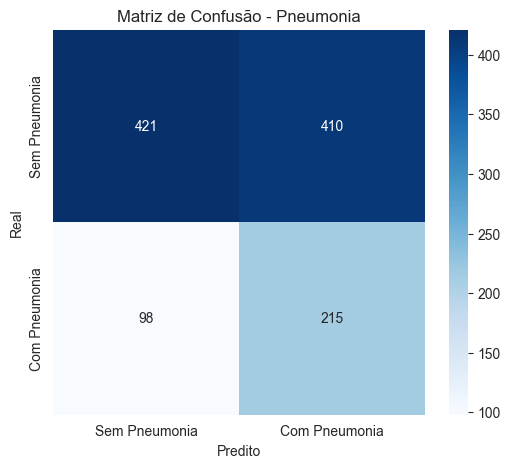

In [112]:
cm = confusion_matrix(y_test, y_pred)
labels_cm = ["Sem Pneumonia", "Com Pneumonia"]

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=labels_cm, yticklabels=labels_cm)
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("matriz de confusao - pneumonia")
plt.show()

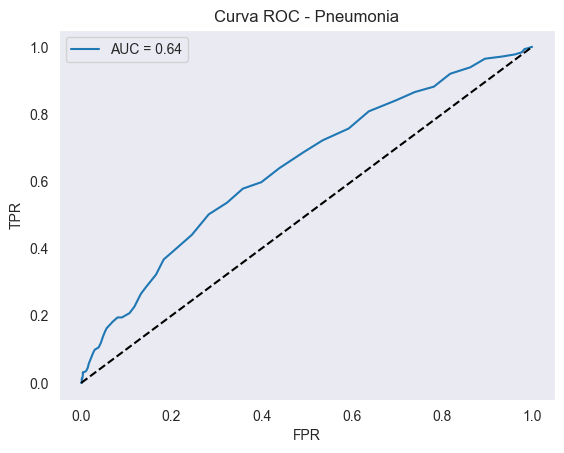

In [113]:
fpr, tpr, _ = roc_curve(y_test, y_probs)
auc = roc_auc_score(y_test, y_probs)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Curva ROC - Pneumonia")
plt.legend()
plt.grid()
plt.show()
